# Installing required libraries

In [19]:
!pip install modAL
!pip install tensorflow==1.13.1
!pip install tensorflow_hub==0.7.0

import numpy as np
import pandas as pd
import re
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
nltk.download('wordnet') #First download the required data 
nltk.download('punkt')

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
from modAL.batch import uncertainty_batch_sampling

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/parulsaini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/parulsaini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data processing for active learning - TREC

In [306]:
LABEL_DICT = {"DESCRIPTION": 0, "ENTITY": 1, "HUMAN": 2, "ABBREVIATION": 3, "LOCATION": 4, "NUMERIC": 5}
label_map = {"DESC": "DESCRIPTION", "ENTY": "ENTITY", "HUM": "HUMAN", "ABBR": "ABBREVIATION", "LOC": "LOCATION",
           "NUM": "NUMERIC"}

def load_data(file_name,split):
    data=[]
    with open(file_name, 'r', encoding='latin1') as f:
        for line in f:
            label = LABEL_DICT[label_map[line.split()[0].split(":")[0]]]
            if split == 'test':
                sentence = (" ".join(line.split()[1:]))
            else:
                sentence = (" ".join(line.split(":")[1:])).lower().strip()
            data.append((sentence, label, split))
    df_part= pd.DataFrame(data,columns=['text','label',split])
    return df_part


#TREC Dataset
#Using data splits from Awasthi - Labelled Exempelars
df_train=load_data('train.txt','train')
df_valid=load_data('valid.txt','valid')
df_test=load_data('test.txt','test')

df_initial_train=load_data('initial_train.txt','initial_train')

#Not taking initial ASTRA labeled data
#df = pd.concat([df_train, df_test,df_valid],ignore_index=True)

#Taking initial ASTRA labeled data
df = pd.concat([df_train, df_test,df_valid,df_initial_train],ignore_index=True)
df.head()

,text,label,train,test,valid,initial_train
0,how did serfdom develop in and then leave russ...,0,train,NaN,NaN,NaN
1,what films featured the character popeye doyle ?,1,train,NaN,NaN,NaN
2,how can i find a list of celebrities ' real na...,0,train,NaN,NaN,NaN
3,what fowl grabs the spotlight after the chines...,1,train,NaN,NaN,NaN
4,what is the full form of .com ?,3,train,NaN,NaN,NaN


# Data processing for active learning - SMS

In [20]:
LABEL_DICT = {"ham": 0, "spam": 1}
def load_data(mode):
    data = pd.read_csv(mode , encoding='latin1')
    sentence = [x.lower().strip() for x in data["v2"].tolist()]
    label = [LABEL_DICT[item] for item in data["v1"].tolist()]
    data = list(zip(sentence,label))
    return data

train=load_data('sms dataset/train.csv')
df_train=pd.DataFrame(train,columns=['text','label'])
df_train['train']='train'

valid=load_data('sms dataset/valid.csv')
df_valid=pd.DataFrame(valid,columns=['text','label'])
df_valid['valid']='valid'

test=load_data('sms dataset/test.csv')
df_test=pd.DataFrame(test,columns=['text','label'])
df_test['test']='test'


#Not taking initial ASTRA labeled data
#df = pd.concat([df_train, df_test,df_valid],ignore_index=True)

#Taking initial ASTRA labeled data
df = pd.concat([df_train, df_test,df_valid,df_initial_train],ignore_index=True)
df.head()

,text,label,train,test,valid
0,goldviking (29/m) is inviting you to be his fr...,1,train,NaN,NaN
1,"i'm in solihull, | do you want anything?",0,train,NaN,NaN
2,u have a secret admirer. reveal who thinks u r...,1,train,NaN,NaN
3,hello lover! how goes that new job? are you th...,0,train,NaN,NaN
4,hey i am really horny want to chat or see me n...,1,train,NaN,NaN


# Pre-processing Text Data

## Remove Punctuation

In [21]:
import string
string.punctuation

#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['clean_text']= df['text'].apply(lambda x:remove_punctuation(x)).apply(lambda x: x.lower())
df.head()

,text,label,train,test,valid,clean_text
0,goldviking (29/m) is inviting you to be his fr...,1,train,NaN,NaN,goldviking 29m is inviting you to be his frien...
1,"i'm in solihull, | do you want anything?",0,train,NaN,NaN,im in solihull do you want anything
2,u have a secret admirer. reveal who thinks u r...,1,train,NaN,NaN,u have a secret admirer reveal who thinks u r ...
3,hello lover! how goes that new job? are you th...,0,train,NaN,NaN,hello lover how goes that new job are you ther...
4,hey i am really horny want to chat or see me n...,1,train,NaN,NaN,hey i am really horny want to chat or see me n...


## Perform Lemmitization to get canonical form of word

In [22]:

#Lemmitization:
from nltk.stem import WordNetLemmatizer
# Init the Wordnet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
 
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)])
    
    
df['text_lemmatized'] = df['clean_text'].apply(lemmatize_text)
df['text_lemmatized'].head()

0    goldviking 29m be invite you to be his friend ...
1                  im in solihull do you want anything
2    u have a secret admirer reveal who think u r s...
3    hello lover how go that new job be you there n...
4    hey i be really horny want to chat or see me n...
Name: text_lemmatized, dtype: object

In [23]:
train_text = df[df['train']=='train']['text_lemmatized'].to_numpy()
test_text =df[df['test']=='test']['text_lemmatized'].to_numpy()
valid_text =df[df['valid']=='valid']['text_lemmatized'].to_numpy()
#initial_train_text =df[df['initial_train']=='initial_train']['text_lemmatized'].to_numpy()
y_train= df[df['train']=='train']['label'].to_numpy()
y_test=df[df['test']=='test']['label'].to_numpy()
y_valid=df[df['valid']=='valid']['label'].to_numpy()
#y_initial_train=df[df['initial_train']=='initial_train']['label'].to_numpy()

## Create Embeddings with ELMO - Execute in Google Colab 

In [ ]:
#Execute in Google Colab to create embeddings
import os
import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/elmo/2"
elmo = hub.Module(module_url,trainable=True)


In [ ]:
def elmo_vectors(x):
    sess_config = tf.ConfigProto()
    sess_config.gpu_options.allow_growth = True
  
    #elmo(x, signature="default", as_dict=True)["elmo"]
    with tf.Session(config=sess_config) as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embeddings = elmo(x.tolist(),signature="default",as_dict=True)["default"]
        return session.run(embeddings)
    

In [152]:
list_train = [train_text[i:i+100] for i in range(0,train_text.shape[0],100)]
list_test = [test_text[i:i+100] for i in range(0,test_text.shape[0],100)]
list_valid = [valid_text[i:i+100] for i in range(0,valid_text.shape[0],100)]
#list_initial_train = [initial_train_text[i:i+100] for i in range(0,initial_train_text.shape[0],100)]

In [ ]:
# Extract ELMo embeddings
elmo_train = [elmo_vectors(x) for x in list_train]
elmo_test = [elmo_vectors(x) for x in list_test]
elmo_valid = [elmo_vectors(x) for x in list_valid]
elmo_initial= [elmo_vectors(x) for x in list_initial_train ]

# TREC Embeddings

In [ ]:
#Concatenate:
elmo_train_new = np.concatenate(elmo_train, axis = 0)
elmo_test_new = np.concatenate(elmo_test, axis = 0)
elmo_valid_new = np.concatenate(elmo_valid, axis = 0)
elmo_initial_new = np.concatenate(elmo_initial, axis = 0)

# save elmo_train_new
pickle_out = open("elmo_train_1218.pickle","wb")
pickle.dump(elmo_train_new, pickle_out)
pickle_out.close()

# save elmo_test_new
pickle_out = open("elmo_test_1218.pickle","wb")
pickle.dump(elmo_test_new, pickle_out)
pickle_out.close()

# save elmo_valid_new
pickle_out = open("elmo_valid_1218.pickle","wb")
pickle.dump(elmo_valid_new, pickle_out)
pickle_out.close()

# save elmo
pickle_out = open("elmo_initial_1218.pickle","wb")
pickle.dump(elmo_initial_new, pickle_out)
pickle_out.close()


In [ ]:
#To load back

# load elmo_train_new
pickle_in = open("elmo_train_1116.pickle", "rb")
elmo_train_new = pickle.load(pickle_in)

# load elmo_test_new
pickle_in = open("elmo_test_1116.pickle", "rb")
elmo_test_new = pickle.load(pickle_in)

# load elmo_valid_new
pickle_in = open("elmo_valid_1116.pickle", "rb")
elmo_valid_new = pickle.load(pickle_in)


# load elmo_valid_new
pickle_in = open("elmo_initial_1218.pickle", "rb")
elmo_initial_new = pickle.load(pickle_in)


# SMS Embeddings

In [126]:
#Concatenate:
elmo_train_new = np.concatenate(elmo_train, axis = 0)
elmo_test_new = np.concatenate(elmo_test, axis = 0)
elmo_valid_new = np.concatenate(elmo_valid, axis = 0)
#elmo_initial_new = np.concatenate(elmo_initial, axis = 0)

# save elmo_train_new
pickle_out = open("elmo_train_sms_1220.pickle","wb")
pickle.dump(elmo_train_new, pickle_out)
pickle_out.close()


# save elmo_test_new
pickle_out = open("elmo_test_sms_1220.pickle","wb")
pickle.dump(elmo_test_new, pickle_out)
pickle_out.close()

# save elmo_valid_new
pickle_out = open("elmo_valid_sms_1220.pickle","wb")
pickle.dump(elmo_valid_new, pickle_out)
pickle_out.close()


In [24]:
#To load back

# load elmo_train_new
pickle_in = open("elmo_train_sms_1220.pickle", "rb")
elmo_train_new = pickle.load(pickle_in)

# load elmo_test_new
pickle_in = open("elmo_test_sms_1220.pickle", "rb")
elmo_test_new = pickle.load(pickle_in)

# load elmo_valid_new
pickle_in = open("elmo_valid_sms_1220.pickle", "rb")
elmo_valid_new = pickle.load(pickle_in)


# Active Learning Module

In [260]:
#Random Intialisation

import random
# TREC Dataser
#n_initial = 68
# SMS Datset
n_initial=73
random.seed(0)


#select any random records to train on
initial_idx = np.random.choice(range(len(elmo_train_new)), size=n_initial, replace=False)

X_initial, y_initial = elmo_train_new[initial_idx], y_train[initial_idx]

X_pool, y_pool = np.delete(elmo_train_new, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
X_pool_text, y_pool_text = np.delete(train_text, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)


In [168]:
#Astra Initialisation
n_initial = 68
#np.random.seed(0)

#select any random records to train on
initial = np.random.choice(range(len(elmo_initial_new)), size=n_initial, replace=False)

X_initial, y_initial = elmo_initial_new[initial], y_initial_train[initial]


# elmo train embedding created without intial, though df contains intial. Run df without initial to create train test valid embeddings
#X_pool, y_pool = np.delete(elmo_train_new, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
#X_pool_text, y_pool_text = np.delete(train_text, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

X_pool, y_pool = elmo_train_new,y_train
X_pool_text, y_pool_text = train_text,y_train

In [230]:
print('initial training data', X_initial.shape[0])
print('unlabelled data', X_pool_text.shape[0])
print('test data', elmo_test_new.shape[0])


initial training data 73
unlabelled data 4429
test data 500


## KNN Classifier with Different Query Strategies

In [ ]:
knn =  KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(
    estimator=knn,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

accuracy_scores = [learner.score(elmo_test_new, y_test)]

print(accuracy_scores)

In [ ]:
knn =  KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(
    estimator=knn,
    query_strategy=margin_sampling,
    X_training=X_initial, y_training=y_initial
)

accuracy_scores = [learner.score(elmo_test_new, y_test)]

print(accuracy_scores)

In [ ]:
knn =  KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(
    estimator=knn,
    query_strategy=entropy_sampling,
    X_training=X_initial, y_training=y_initial
)

accuracy_scores = [learner.score(elmo_test_new, y_test)]

print(accuracy_scores)

## Random Forest Classifier with Different Query Strategies

In [ ]:
learner = ActiveLearner(
    estimator=RandomForestClassifier( random_state =0),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

In [ ]:
learner = ActiveLearner(
    estimator=RandomForestClassifier( random_state =0),
    query_strategy=margin_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

In [ ]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(  random_state =0),
    query_strategy=entropy_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

## SVM Classifier with Different Query Strategies

In [169]:
svm_classifier = SVC(decision_function_shape='ovr', probability=True, kernel='linear')
learner = ActiveLearner(
    estimator=svm_classifier,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

[0.724]


In [160]:
svm_classifier = SVC(decision_function_shape='ovr', probability=True,kernel='linear')
learner = ActiveLearner(
    estimator=svm_classifier,
    query_strategy=margin_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

[0.724]


In [192]:
svm_classifier = SVC(decision_function_shape='ovr', probability=True,kernel='linear')
learner = ActiveLearner(
    estimator=svm_classifier,
    query_strategy=entropy_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

[0.67]


## Logistic Regression Classifier with Different Query Strategies

In [249]:
random.seed(0)
LR= LogisticRegression(multi_class='ovr')
learner = ActiveLearner(
    estimator=LR,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

[0.97]


In [255]:
np.random.seed(0)
LR= LogisticRegression(multi_class='ovr')
learner = ActiveLearner(
    estimator=LR,
    query_strategy=margin_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

[0.97]


In [261]:
np.random.seed(0)
LR= LogisticRegression(multi_class='ovr')
learner = ActiveLearner(
    estimator=LR,
    query_strategy=entropy_sampling,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
print(accuracy_scores)

[0.97]


## Sampling Instances for Human Annotation

In [250]:
ms = []
es = []
us = []

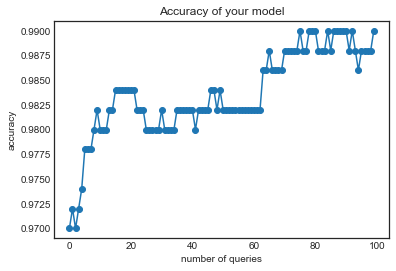

['do you see that film']
What is the label?


/Users/parulsaini/miniforge3/envs/nn/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [262]:
np.random.seed(0)
accuracy_scores = [learner.score(elmo_test_new, y_test)]
n_queries = 100
q_id=[]

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(X_pool)
    q_id.append(query_idx)
    with plt.style.context('seaborn-white'):
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')
     
    
    print(X_pool_text[query_idx])
    print("What is the label?")
    #y_new = np.array([int(input())], dtype=int)
    y_new = y_pool[query_idx]
    learner.teach(query_inst.reshape(1, -1), y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(elmo_test_new, y_test))
    

In [263]:
LABEL_DICT = {"DESCRIPTION": 0, "ENTITY": 1, "HUMAN": 2, "ABBREVIATION": 3, "LOCATION": 4, "NUMERIC": 5}

y_pred = learner.predict(elmo_test_new)
acc = [accuracy_score(y_pred, y_test)]
print(acc)

[0.99]


### Extracting sampled instances after labeling

In [150]:
# write selected queries to file
label_mapping = {"DESC": 0, "ENTY": 1, "HUM": 2, "ABBR": 3, "LOC": 4, "NUM": 5}
def write_to_file():
    output_text = [k1+":"+df_train['text'].iloc[q_id[i]].to_list()[0] for k1, v1 in label_mapping.items() for i in range(len(q_id)) if v1 == df_train['label'].iloc[q_id[i]].to_list()[0]]

    with open("selected_labelled_new.txt", "w") as f:
        for line in output_text:
            f.write(line + "\n")
        f.close()

    with open("train-without-duplicates-original.txt", 'r') as train_file, open("selected_unlabeled_new.txt", "w") as new_file:
        for line in train_file:
            if line.strip('\n') not in output_text:
                new_file.write(line)
        train_file.close()
        new_file.close()

write_to_file()


In [264]:
es.append(accuracy_scores)

In [258]:
ms.append(accuracy_scores)

In [252]:
us.append(accuracy_scores)

In [165]:
#knn results:
us_knn = us.copy()
ms_knn = ms.copy()
es_knn = es.copy()

In [182]:
#rf results
us_rf = us.copy()
ms_rf = ms.copy()
es_rf = es.copy()

In [201]:
#linear svm reulsts
us_svm = us.copy()
ms_svm = ms.copy()
es_svm = es.copy()

In [268]:
#Logistic regression reulsts
us_lr = us.copy()
ms_lr = ms.copy()
es_lr = es.copy()

## Plotting behavious of different models for different query strategies

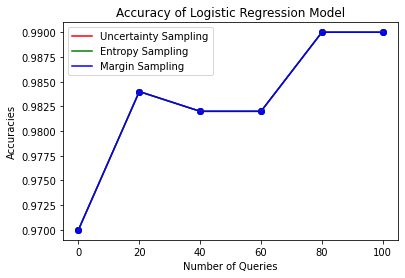

<Figure size 1440x1440 with 0 Axes>

In [269]:
plt.title('Accuracy of Logistic Regression Model')
x= [0,20,40,60,80,100]
y1= [us[0][0],us[0][20],us[0][40],us[0][60],us[0][80],us[0][100]]
y2 = [ms[0][0],ms[0][20],ms[0][40],ms[0][60],ms[0][80],ms[0][100]]
y3 = [es[0][0],es[0][20],es[0][40],es[0][60],es[0][80],es[0][100]]
plt.plot(x,y1,color='red',label='Uncertainty Sampling')
plt.scatter(x,y1,color='red')
plt.plot(x,y3,  color='green', label='Entropy Sampling')
plt.scatter(x,y3,color='green')
plt.plot(x,y2,  color='blue', label='Margin Sampling')
plt.scatter(x,y2,color='blue')

plt.xlabel("Number of Queries")
plt.ylabel("Accuracies")
plt.legend()
plt.figure(figsize=(20,20))
plt.show()

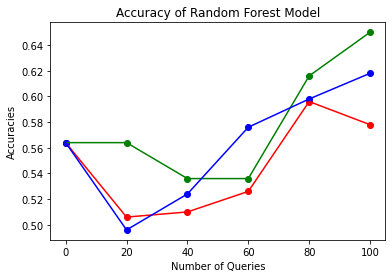

<Figure size 1440x1440 with 0 Axes>

In [166]:
plt.title('Accuracy of KNN Model')
x= [0,20,40,60,80,100]
y1= [us[0][0],us[0][20],us[0][40],us[0][60],us[0][80],us[0][100]]
y2 = [ms[0][0],ms[0][20],ms[0][40],ms[0][60],ms[0][80],ms[0][100]]
y3 = [es[0][0],es[0][20],es[0][40],es[0][60],es[0][80],es[0][100]]
plt.plot(x,y1,color='red',label='Uncertainty Sampling k=3')
plt.scatter(x,y1,color='red')
plt.plot(x,y3,  color='green', label='Entropy Sampling k=3')
plt.scatter(x,y3,color='green')
plt.plot(x,y2,  color='blue', label='Margin Sampling k=3')
plt.scatter(x,y2,color='blue')

plt.xlabel("Number of Queries")
plt.ylabel("Accuracies")
#plt.legend()
plt.figure(figsize=(20,20))
plt.show()

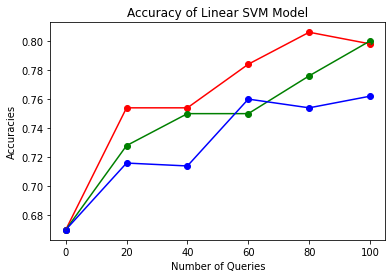

<Figure size 1440x1440 with 0 Axes>

In [202]:
plt.title('Accuracy of Linear SVM Model')
x= [0,20,40,60,80,100]
y1= [us[0][0],us[0][20],us[0][40],us[0][60],us[0][80],us[0][100]]
y2 = [ms[0][0],ms[0][20],ms[0][40],ms[0][60],ms[0][80],ms[0][100]]
y3 = [es[0][0],es[0][20],es[0][40],es[0][60],es[0][80],es[0][100]]
plt.plot(x,y1,color='red',label='Uncertainty Sampling k=5')
plt.scatter(x,y1,color='red')
plt.plot(x,y3,  color='green', label='Entropy Sampling k=5')
plt.scatter(x,y3,color='green')
plt.plot(x,y2,  color='blue', label='Margin Sampling k=9')
plt.scatter(x,y2,color='blue')

plt.xlabel("Number of Queries")
plt.ylabel("Accuracies")
#plt.legend()
plt.figure(figsize=(20,20))
plt.show()

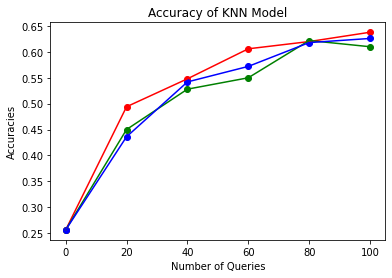

<Figure size 1440x1440 with 0 Axes>

In [101]:
plt.title('Accuracy of KNN Model')
x= [0,20,40,60,80,100]
y1= [us[0][0],us[0][20],us[0][40],us[0][60],us[0][80],us[0][100]]
y2 = [ms[0][0],ms[0][20],ms[0][40],ms[0][60],ms[0][80],ms[0][100]]
y3 = [es[0][0],es[0][20],es[0][40],es[0][60],es[0][80],es[0][100]]
plt.plot(x,y1,color='red',label='Uncertainty Sampling k=5')
plt.scatter(x,y1,color='red')
plt.plot(x,y3,  color='green', label='Entropy Sampling k=5')
plt.scatter(x,y3,color='green')
plt.plot(x,y2,  color='blue', label='Margin Sampling k=9')
plt.scatter(x,y2,color='blue')

plt.xlabel("Number of Queries")
plt.ylabel("Accuracies")
#plt.legend()
plt.figure(figsize=(20,20))
plt.show()

# Supervised Learning - Labelled Only


In [25]:
#Random Intialisation
#select any random records to train on
#TREC
#n_initial1 = 68
#SMS
n_initial1 = 73
np.random.seed(0)
initial_idx1 = np.random.choice(range(len(elmo_train_new)), size=n_initial1, replace=False)

X_initial1, y_initial1 = elmo_train_new[initial_idx1], y_train[initial_idx1]

X_pool1, y_pool1 = np.delete(elmo_train_new, initial_idx1, axis=0), np.delete(y_train, initial_idx1, axis=0)


In [148]:
#Astra Initialisation
n_initial = 68
#np.random.seed(0)

#select any random records to train on
initial_idx1 = np.random.choice(range(len(elmo_initial_new)), size=n_initial, replace=False)

X_initial1, y_initial1 = elmo_initial_new[initial_idx1], y_initial_train[initial_idx1]

X_pool1, y_pool1 = elmo_train_new,y_train

## KNN

In [30]:
#KNeighbors Algorithm
classifier1 = KNeighborsClassifier(n_neighbors =3)
classifier1.fit(X_initial1,y_initial1)
print("train score: ",classifier1.score(X_initial1,y_initial1))
y_pred1 = classifier1.predict(elmo_test_new)
scKNN = accuracy_score(y_test,y_pred1)
print("\n\n[+]accuracy score of KNeighbors Algorithm = " ,scKNN)

train score:  0.9863013698630136


[+]accuracy score of KNeighbors Algorithm =  0.95


## Random Forest

In [29]:
classifier3 = RandomForestClassifier(random_state =0)
classifier3.fit(X_initial1,y_initial1)
print("train score: ",classifier3.score(X_initial1,y_initial1))
y_pred3 = classifier3.predict(elmo_test_new)
scRF = accuracy_score(y_test,y_pred3)
print("accuracy score of RandomForest Algorithm = " ,scRF)

train score:  1.0
accuracy score of RandomForest Algorithm =  0.884


## SVM

In [28]:
classifier4 = SVC(decision_function_shape='ovr', probability=True,kernel='linear')
classifier4.fit(X_initial1,y_initial1)
print("train score: ",classifier4.score(X_initial1,y_initial1))
y_pred4 = classifier4.predict(elmo_test_new)
SVC_Linear = accuracy_score(y_test,y_pred4)
print("accuracy score of SVC Algorithm = " ,SVC_Linear)

train score:  1.0
accuracy score of SVC Algorithm =  0.954


## Logistic Regression

In [27]:
classifier5 = LogisticRegression(multi_class='ovr')
classifier5.fit(X_initial1,y_initial1)
print("train score: ",classifier5.score(X_initial1,y_initial1))
y_pred5 = classifier5.predict(elmo_test_new)
LR = accuracy_score(y_test,y_pred5)
print("accuracy score of LR Algorithm = " ,LR)

train score:  1.0
accuracy score of LR Algorithm =  0.94


# Comparitive Plots - Weak Supervision Frameworks & Active Learner

## TREC Dataset

In [7]:
# LR with uncertanty sampling
active_best= 82.4 
snorkel = 57.6
imply_loss = 77
#with 68 labelled instances
knn=56.4
rf=59.4
svc=67
LR = 65.2
L_only =67
#with 168 labelled instances
knn1 =66.6
rf1 = 68.2
svc1= 79.2
lr1= 79.8

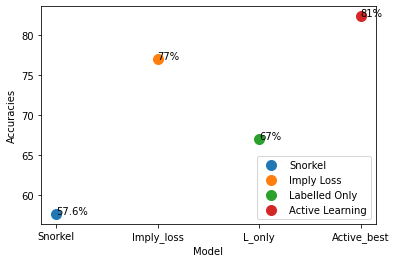

In [9]:
import matplotlib.pyplot as plt
x = ['Snorkel','Imply_loss','L_only','Active_best']
y = [snorkel,imply_loss,L_only,active_best]
acc= ['57.6%','77%','67%','81%']
fig, ax = plt.subplots()
ax.scatter(x[0], y[0],s=100,label='Snorkel')
ax.scatter(x[1], y[1],s=100,label='Imply Loss')
ax.scatter(x[2], y[2],s=100,label='Labelled Only')
ax.scatter(x[3], y[3],s=100,label='Active Learning')
ax.legend()
plt.ylabel("Accuracies")
plt.xlabel("Model")
for i, txt in enumerate(acc):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

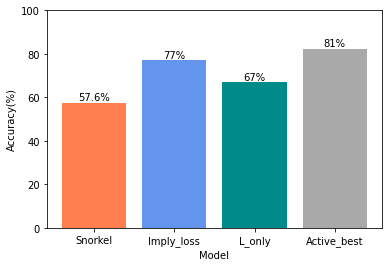

In [12]:
ax = plt.figure()
#plt.title('Test Accuracy Comparison - TREC Dataset')
plt.bar(acc,y, color={'darkcyan', 'coral', 'cornflowerblue', 'darkgrey'})
plt.xticks(np.arange(4),x)
plt.ylabel("Accuracy(%)")
plt.xlabel("Model")
plt.ylim([0,100])
for i in range(len(acc)):
    plt.text(i, y[i]+1, acc[i], ha='center')
plt.show()

## SMS Dataset

In [13]:
#73 labelled instances initially, 100 actively sampled
active_best= 99
snorkel = 97.47
imply_loss = 98.6
L_only = 98

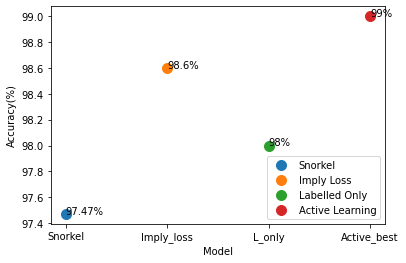

In [14]:
import matplotlib.pyplot as plt
x = ['Snorkel','Imply_loss','L_only','Active_best']
y = [snorkel,imply_loss,L_only,active_best]
acc= ['97.47%','98.6%','98%','99%']
fig, ax = plt.subplots()
ax.scatter(x[0], y[0],s=100,label='Snorkel')
ax.scatter(x[1], y[1],s=100,label='Imply Loss')
ax.scatter(x[2], y[2],s=100,label='Labelled Only')
ax.scatter(x[3], y[3],s=100,label='Active Learning')
ax.legend()
plt.ylabel("Accuracy(%)")
plt.xlabel("Model")

for i, txt in enumerate(acc):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

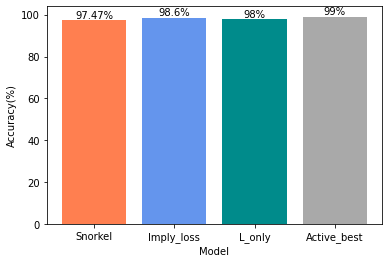

In [15]:
ax = plt.figure()
#plt.title('Test Accuracy Comparison - SMS Dataset')
plt.bar(acc,y, color={'darkcyan', 'coral', 'cornflowerblue', 'darkgrey'})
plt.xticks(np.arange(4),x)
plt.ylabel("Accuracy(%)")
plt.xlabel("Model")
for i in range(len(acc)):
    plt.text(i, y[i]+1, acc[i], ha='center')
plt.show()

## ASTRA +AL

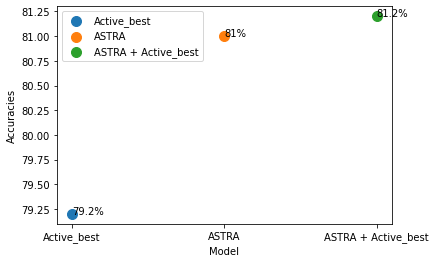

In [16]:
astra= 81
active_best = 79.2
astra_al = 81.2
import matplotlib.pyplot as plt
x = ['Active_best','ASTRA','ASTRA + Active_best']
y = [active_best,astra,astra_al]
acc= ['79.2%','81%','81.2%']
fig, ax = plt.subplots()
ax.scatter(x[0], y[0],s=100,label='Active_best')
ax.scatter(x[1], y[1],s=100,label='ASTRA')
ax.scatter(x[2], y[2],s=100,label='ASTRA + Active_best')
ax.legend()
plt.ylabel("Accuracies")
plt.xlabel("Model")

for i, txt in enumerate(acc):
    ax.annotate(txt, (x[i], y[i]))
plt.show()



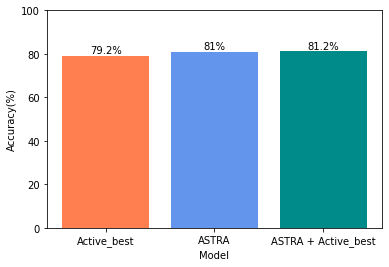

In [17]:
import numpy as np
ax = plt.figure()
#plt.title('Test Accuracy Comparison')
plt.bar(acc,y, color={'darkcyan', 'coral', 'cornflowerblue', 'darkgrey'})
plt.xticks(np.arange(3),x)
plt.ylabel("Accuracy(%)")
plt.xlabel("Model")
plt.ylim([0,100])
for i in range(len(acc)):
    plt.text(i, y[i]+1, acc[i], ha='center')
plt.show()